L0 average compaction duration[secs]: 0.5193150487804877
L1 average compaction duration[secs]: 1.0614518181818182
L0 average time interval between two compactions[secs]: 7.1823602477837
L1 average time interval between two compactions[secs]: 24.121692300211098


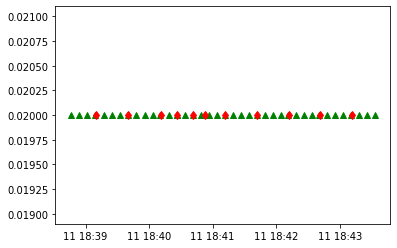

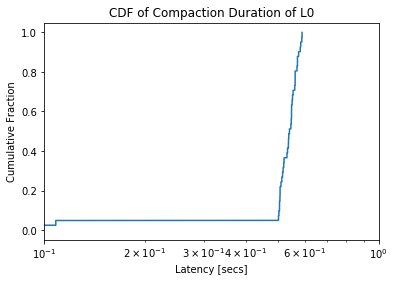

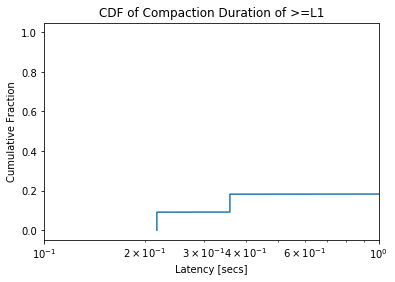

In [1]:
import sys
import numpy as np
from pandas import read_csv
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt
utc=pytz.UTC

if0='flush_job_timestamps.csv'     # Compaction for L0
if1='compact_job_timestamps.csv'   # Compaction for other levels
id0=read_csv(if0, parse_dates=True, squeeze=True, sep=',', header=None)
id1=read_csv(if1, parse_dates=True, squeeze=True, sep=',', header=None)

# L0
id0len = len(id0.values)
x_l0_timestamps = [] # flush(L0) timestamps
x_l0_timestamps_us = [] #timestamps in microseconds for L0
y_l0_dummy = [] # dummp y value for L0
dur_l0 = [] # durations(width of compaction) for l0

# >=L1
id1len = len(id1.values)
x_l1_timestamps = [] # flush(L1) timestamps
x_l1_timestamps_us = [] #timestamps in microseconds for L1
y_l1_dummy = [] # dummp y value for L1
dur_l1 = [] # durations(width of compaction) for l1

# L0 compaction timestamps and durations
for i in range(id0len):
    x_l0_timestamps.append((parser.parse(id0.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    dur_l0.append(id0.values[i,5]/1000000)
    y_l0_dummy.append(0.02)
    x_l0_timestamps_us.append(id0.values[i,3])
# >=L1 compaction timestamps and durations
for i in range(id1len):
    x_l1_timestamps.append((parser.parse(id1.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    dur_l1.append(id1.values[i,5]/1000000)
    y_l1_dummy.append(0.02)
    x_l1_timestamps_us.append(id1.values[i,3])

cdf_dur_l0_ordered = [] # compaction durations for L0
cdf_perc_l0 = [] # percentage for L0
cdf_dur_l1_ordered = [] # compaction durations for L1
cdf_perc_l1 = [] # percentage for L1
dur_l0.sort()
dur_l1.sort()

# CDF of L0
for i in range(0, 10000, 2):
    cdf_dur_l0_ordered.append(dur_l0[int(i/10000. * len(dur_l0))])
    cdf_perc_l0.append(i/10000.)
# CDF of >=L1
for i in range(0, 10000, 2):
    cdf_dur_l1_ordered.append(dur_l1[int(i/10000. * len(dur_l1))])
    cdf_perc_l1.append(i/10000.)

avg_dur_l0 = 0 # average compaction duration for L0
avg_gap_l0 = 0 # average time interval between two compactions for L0
avg_dur_l1 = 0 # average compaction duration for >=L1
avg_gap_l1 = 0 # average time interval between two compactions for >=L1

# L0 avgs
for i in range(len(dur_l0)):
    avg_dur_l0 = avg_dur_l0 + dur_l0[i]
avg_dur_l0 = avg_dur_l0 / len(dur_l0)
for i in range(len(x_l0_timestamps_us)-1):
    avg_gap_l0 = avg_gap_l0 + x_l0_timestamps_us[i+1] - x_l0_timestamps_us[i] - dur_l0[i]
avg_gap_l0 = avg_gap_l0 / (len(x_l0_timestamps_us)-1)
# >=L1 avgs
for i in range(len(dur_l1)):
    avg_dur_l1 = avg_dur_l1 + dur_l1[i]
avg_dur_l1 = avg_dur_l1 / len(dur_l1)
for i in range(len(x_l1_timestamps_us)-1):
    avg_gap_l1 = avg_gap_l1 + x_l1_timestamps_us[i+1] - x_l1_timestamps_us[i] - dur_l1[i]
avg_gap_l1 = avg_gap_l1 / (len(x_l1_timestamps_us)-1)

print("L0 average compaction duration[secs]:",avg_dur_l0)
print("L1 average compaction duration[secs]:",avg_dur_l1)

print("L0 average time interval between two compactions[secs]:",avg_gap_l0/1000000)
print("L1 average time interval between two compactions[secs]:",avg_gap_l1/1000000)

p1 = plt.figure()
ax1 = p1.add_subplot(111)
ax1.plot(x_l0_timestamps, y_l0_dummy, label='4096 KiB',marker='^', c='g', linestyle='')
ax1.plot(x_l1_timestamps, y_l1_dummy, label='4096 KiB',marker='d', c='r', linestyle='')

p2 = plt.figure()
ax2 = p2.add_subplot(111)
ax2.set_xscale('log')
ax2.set_xlim(0.1,1)
ax2.plot(cdf_dur_l0_ordered, cdf_perc_l0, label='cdf of compaction')
ax2.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of Compaction Duration of L0')

p3 = plt.figure()
ax3 = p3.add_subplot(111)
ax3.set_xscale('log')
ax3.set_xlim(0.1,1)
ax3.plot(cdf_dur_l1_ordered, cdf_perc_l1, label='cdf of compaction')
ax3.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of Compaction Duration of >=L1')

plt.show()
plt.close()
